In [1]:
from google.colab import drive 
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [2]:
# !pip install tensorflow==2.7.0

In [3]:
%tensorflow_version 2.7.0
import tensorflow as tf 
print(tf.__version__)
import keras
keras.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.9.2


'2.9.0'

In [4]:
# !unzip -u '/content/drive/My Drive/Wipro.zip' -d '/content/drive/My Drive/assignment'   

In [5]:
# Importing the Libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import re
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
# from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input
from keras.preprocessing.text import Tokenizer
import numpy as np
from keras.layers import Dense, GlobalAveragePooling2D, Embedding, LSTM, multiply, Flatten
from keras.models import Model
from keras import preprocessing, Input
import os
import itertools
import numpy as np
from PIL import Image, ImageFile
from keras.preprocessing import image
from keras_preprocessing.sequence import pad_sequences
import keras
import h5py
from keras import optimizers
from keras.models import load_model
from keras.layers.core import Reshape, Dropout
from keras.utils.vis_utils import plot_model
import os
import matplotlib.pyplot as plt
from keras import regularizers
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# text cleaning
STOPWORDS = set(stopwords.words('english'))
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
EMAIL = re.compile('^([a-zA-Z0-9_\-\.]+)@([a-zA-Z0-9_\-\.]+)\.([a-zA-Z]{2,5})$')

In [7]:
#path for saving models and input data
Training_path = os.getcwd()+"/drive/My Drive/assignment/Wipro/MultiOFF_Dataset/Split Dataset/Training_meme_dataset.csv"
Validation_path = os.getcwd()+"/drive/My Drive/assignment/Wipro/MultiOFF_Dataset/Split Dataset/Validation_meme_dataset.csv"
Testing_path = os.getcwd()+"/drive/My Drive/assignment/Wipro/MultiOFF_Dataset/Split Dataset/Testing_meme_dataset.csv"
img_dir = os.getcwd()+"/drive/My Drive/assignment/Wipro/MultiOFF_Dataset/Labelled Images"
outputPath =  os.getcwd()+"/drive/My Drive/assignment/Assignment2/"

In [8]:
## Methods for preprocessing the dataset for training and testing

# Clean Text 
def clean_text(text):
    """
        text: a string        
        return: modified initial string
    """
    text = text.lower()
    text = EMAIL.sub('', text)   
    text = REPLACE_BY_SPACE_RE.sub(' ',text)              
    text = BAD_SYMBOLS_RE.sub('',text)      
    text = text.replace('x','')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)    
    return text

### encoding labels
def encode_label(DataFrame, Label_col):
    t_y = DataFrame[Label_col].values
    Encoder = LabelEncoder()
    y = Encoder.fit_transform(t_y)
    DataFrame[Label_col] = y

#image array creation
def create_img_array(img_dirct):
    all_imgs = []
    for root, j, files in os.walk(img_dirct):
        for file in files:
            file = root+'/' + file
            all_imgs.append(file)
    return all_imgs

## image path 
def create_img_path(DF, Col_name, img_dir):
    img_path = [img_dir+'/' + name for name in DF[Col_name]]
    return img_path

#### preprocess text 
def preprocess_text(Training_path,Validation_path, Testing_path):
    # function to preprocess input
    training_DF = pd.read_csv(Training_path, sep = ',')
    validation_DF = pd.read_csv(Validation_path, sep = ',')
    testing_DF = pd.read_csv(Testing_path, sep = ',')

    # encoding all the labels 
    encode_label(testing_DF,'label')
    encode_label(training_DF, 'label')
    encode_label(validation_DF, 'label')

    clean_text(training_DF['sentence'][0])

    # Processing the text
    training_DF['sentence'] = training_DF['sentence'].apply(clean_text)
    testing_DF['sentence'] = testing_DF['sentence'].apply(clean_text)
    validation_DF['sentence'] = validation_DF['sentence'].apply(clean_text)

    return training_DF, testing_DF, validation_DF


# Function that returns image reading from the path
def get_input(path):
    # Loading image from given path
    # and resizing it to 224*224*3 format
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    img = keras.utils.load_img(path, target_size=(224,224))    
    return(img)

# Function to get the output
# returns an array of labels
def get_output(path,label_file=None):
    # Spliting the path and take out the image id    
    filename = path.split('/')[-1]
    # Taking list of labels
    labels = list(label_file[label_file['image_name'] == filename]['label'].values)
    # for duplicate selecting labels
    if len(labels) <= 2:
        label = labels[0]
    elif len(labels) > 2:
        uni_label = list(set(labels))
        count_label = [labels.count(lab) for lab in uni_label]
        lab_idx = count_label.index(max(count_label))
        label = uni_label[lab_idx]
    return label

# Takes in image and preprocess it
def process_input(img):
    # Converting image to array    
    img_data = keras.utils.img_to_array(img)
    # Adding one more dimension to array    
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    return(img_data)


# Text , Image and Label batch generation 
def img_text_generator(files, padded_seq, y, batch_size=None):
    """
        padded_seq: vectorized padded text sequence 
        y: label of the text
        batch_size: Number of observations to be selected at a time
        
        return: generator object of text data
    """
    while True:
        batch_idxs = np.random.choice(a = list(range(len(padded_seq))), size=batch_size) #Selecting the random batch indexes    
        batch_input_txt = [] # Initializing batch input text
        batch_input_img = [] # Initializing batch input image
        batch_output = [] # Initializing batch output
        
        # Traversing through the batch indexes
        for batch_idx in batch_idxs:
            input_txt = padded_seq[batch_idx] # selecting padded sequences from the batch
            output = y[batch_idx] # Selecting label  
            input_img = get_input(files[batch_idx])
            input_img = process_input(input_img)
            batch_input_txt.append(input_txt) # Appending the input (text vector)
            batch_input_img.append(input_img[0])
            batch_output.append(output) # Appending the label
        
        # Return a tuple of (input,output) to feed the network
        batch_x1 = np.array( batch_input_img )
        batch_x2 = np.array( batch_input_txt )
        batch_y = np.array( batch_output )
        yield ([batch_x1, batch_x2], batch_y)
 

In [9]:
#word Embedding : GloVe representation
GLOVE_DIR = os.getcwd()+"/drive/My Drive/assignment/Wipro/glove.6B"
EMBEDDING_DIM = 50   # Embedding dimensions
maxlen=1000 # for vectors

In [10]:
#reading data 
def read_data(file_name):
  #Opening file
    with open(file_name,'r', encoding="utf8") as f:
      #Creating empty set and dictonary for vocab and word respectively
        word_vocab = set() 
        word2vector = {}
        #Iterating over each line of file
        for line in f:
            #Spliting lines
            line_ = line.strip() 
            #Splitting words
            words_Vec = line_.split()            
            word_vocab.add(words_Vec[0])
            word2vector[words_Vec[0]] = np.array(words_Vec[1:],dtype=float)
    print("Total Words in DataSet:",len(word_vocab))
    return word_vocab,word2vector

In [11]:
# Dividing data in test, train, validation
training_DF, testing_DF, validation_DF = preprocess_text(Training_path,Validation_path, Testing_path)

In [12]:
training_DF.head(2)

image_name                                           sentence  label
0  LJ3r8Gy.jpg.png  official bernie sanders drinking game every ti...      0
1      qDnIIHA.png  228 pm wall inside nazi gas chamber dwebs demo...      1

In [13]:
validation_DF.head(2)

image_name                                           sentence  label
0  Xxc4mjq.png  like ike like ike frank culotta republican clu...      1
1  ZffTHk2.png                                         glory bern      1

In [14]:
testing_DF.head(2)

image_name                                           sentence  label
0  jyxHhiB.png  3 hrs black nurse connecticut asked trump brin...      1
1  we4hhWi.png  nt believe women rights andlthink gays hanged ...      1

In [15]:
# Processing image and text for each set
# Creating train, test and validation image path
train_img_path = create_img_path(training_DF,'image_name', img_dir)
test_img_path = create_img_path(testing_DF,'image_name', img_dir)
val_img_path = create_img_path(validation_DF,'image_name', img_dir)

# Processing the text
training_DF['sentence'] = training_DF['sentence'].apply(clean_text)
testing_DF['sentence'] = testing_DF['sentence'].apply(clean_text)
validation_DF['sentence'] = validation_DF['sentence'].apply(clean_text)

In [16]:
# Vectorising text
# process the whole observation into single list
train_text_list=list(training_DF['sentence'])
test_text_list = list(testing_DF['sentence'])
val_text_list = list(validation_DF['sentence'])

# Creating vectors for train, test, validation
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(train_text_list)
sequences_train = tokenizer.texts_to_sequences(train_text_list)
sequences_test = tokenizer.texts_to_sequences(test_text_list)
sequences_val = tokenizer.texts_to_sequences(val_text_list)

x_train = pad_sequences(sequences_train, maxlen=maxlen)
x_test = pad_sequences(sequences_test, maxlen=maxlen)
x_val = pad_sequences(sequences_val, maxlen=maxlen)

# encoding all the labels 
y_test = testing_DF['label']
y_train = training_DF['label']
y_val = validation_DF['label']

In [17]:
# Creating train, test, val, generator for meme
img_txt_gen_train = img_text_generator(train_img_path, x_train, y_train, batch_size=8)
img_txt_gen_test = img_text_generator(test_img_path, x_test, y_test, batch_size=1)
img_txt_gen_val = img_text_generator(val_img_path, x_val, y_val, batch_size=1)

In [18]:
# Dataset words and vectors
vocab, w2v = read_data(os.path.join(GLOVE_DIR, "glove.6B.50d.txt"))

# number of tokens 
word_index = tokenizer.word_index
num_tokens = len(word_index)

#Creating embeddding weight matrix
embedding_matrix = np.zeros((num_tokens + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = w2v.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Total Words in DataSet: 400000


# **Text Embeddings**

In [19]:
#Creating embedded layer using embedded matrix as weight matrix
embedding_layer = Embedding(num_tokens + 1, EMBEDDING_DIM, weights=[embedding_matrix], trainable = False)
# Defining input LSTM layer
main_input = Input(shape=(maxlen,), dtype='float32', name='main_input')
# Adding embedding layer
embedded_sequences = embedding_layer(main_input)
lstm1 = LSTM(32, return_state=True)
encoder_outputs,state_h,state_c = (lstm1)(embedded_sequences)
states= [state_h,state_c]
# Defining second LSTM
lstm2=LSTM(32, return_sequences=True, return_state=True)

# Adding initial state as state of previous LSTM
decoder_out,_,_=lstm2(embedded_sequences,initial_state=states)
# Adding dense layer 
decoder_dense = (Dense(440, activation='relu'))(decoder_out) 
lstm_out = Flatten(name="flatten_2")(decoder_dense)
# Output of text model

# Defining text model
txt_model = Model(inputs = [main_input], outputs=lstm_out)

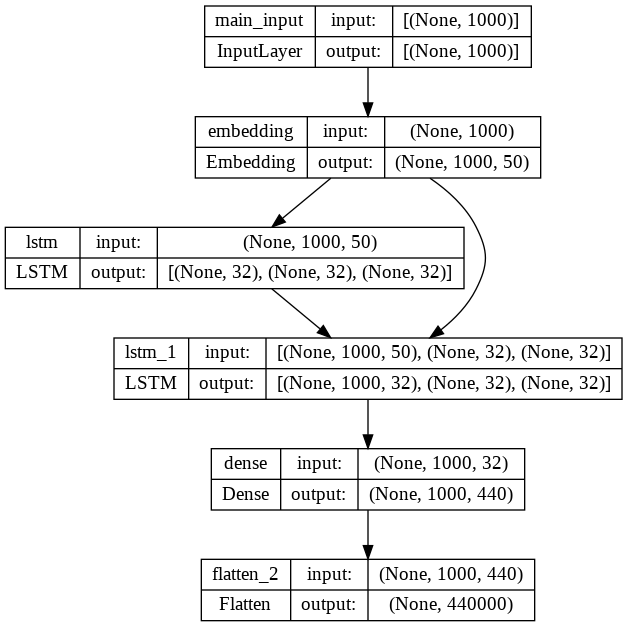

In [20]:
# Plot text embeddings plot
plot_model(txt_model, to_file=outputPath+'Stack_LSTM_txt_model.png', show_shapes=True, show_layer_names=True)

# **Image Features**

In [21]:
# define pretrained image model for classification
def Image_model(base_model):
    # Freezing all the trainable layers
    for layer in base_model.layers:
        layer.trainable = True
    # Creating output layer
    x = base_model.output
    # Adding pooling layer before the output
    x = GlobalAveragePooling2D()(x)    
    return x


In [22]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0

# create base model with imagenet weights
pre_trained_image_model = EfficientNetV2B0(weights='imagenet', include_top=False)

# Building img_prediction layer using Image_model
base_img = Image_model(pre_trained_image_model)

# Defining image model
img_model = Model(inputs = [pre_trained_image_model.input], outputs=base_img)


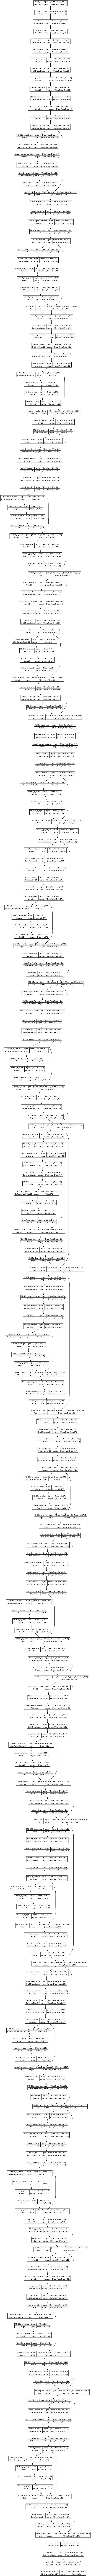

In [23]:
# Plotting image feature 
plot_model(img_model, to_file=outputPath+'EfficientNetV2B0_img_model.png', show_shapes=True, show_layer_names=True)

# **Combine Text Embeddings and Image Features**

In [24]:
# Concatenating output embeddings and features
con_layer = keras.layers.concatenate([txt_model.output, img_model.output])
con_layer= Dropout(rate=0.3)(con_layer)  #dropout layer
out = Dense(1,activation='sigmoid')(con_layer) # Classifier layer

# Defining model input and output
com_model = Model(inputs = [img_model.input, txt_model.input], outputs=out)

# compiling the combined model
adam = keras.optimizers.Adam(lr=1e-3) # Optimizer Adam
com_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


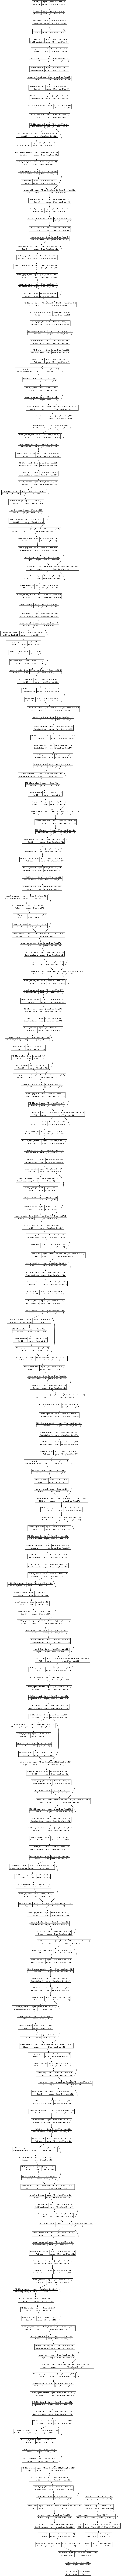

In [25]:
# PlotTing combined model
plot_model(com_model, to_file=outputPath+'Stack_LSTM_EfficientNetV2B0_mul_model.png', show_shapes=True, show_layer_names=True)

In [26]:
# 0-Non-offensive and 1-Offensive (Non-offensive labels are greater than Offensive )
# Assigning class weights to manage the class imbalance
class_weight = {1: 1.4,
                0: 1.0}


In [27]:
# Training model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Training Parameters
step_epochs = 2
val_steps = 149
patience = 10
num_epochs= 50

#Callback earlystopping 
callbacks = EarlyStopping(monitor='val_loss', patience=patience,mode="min",restore_best_weights=True,verbose=2)

# Model Fitting 
history=com_model.fit_generator(img_txt_gen_train, epochs=num_epochs, validation_steps = 149, steps_per_epoch=2, validation_data=img_txt_gen_val, 
                                shuffle=True, class_weight=class_weight, callbacks=[callbacks])

# Saving combined model
com_model.save(outputPath+'Stack_LSTM_EfficientNetV2B0_mul_model.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
2/2 [==============================] - 27s 9s/step - loss: 0.8182 - accuracy: 0.3750 - val_loss: 0.6869 - val_accuracy: 0.5436
Epoch 2/50
2/2 [==============================] - 8s 8s/step - loss: 0.8803 - accuracy: 0.1875 - val_loss: 0.7047 - val_accuracy: 0.5168
Epoch 3/50
2/2 [==============================] - 7s 7s/step - loss: 0.8663 - accuracy: 0.4375 - val_loss: 0.7525 - val_accuracy: 0.3691
Epoch 4/50
2/2 [==============================] - 6s 6s/step - loss: 0.8314 - accuracy: 0.3125 - val_loss: 0.7408 - val_accuracy: 0.3960
Epoch 5/50
2/2 [==============================] - 7s 7s/step - loss: 0.7994 - accuracy: 0.5625 - val_loss: 0.7484 - val_accuracy: 0.3893
Epoch 6/50
2/2 [==============================] - 7s 7s/step - loss: 0.8206 - accuracy: 0.4375 - val_loss: 0.7143 - val_accuracy: 0.5168
Epoch 7/50
2/2 [==============================] - 7s 7s/step - loss: 0.7794 - accuracy: 0.6250 - val_loss: 0.6853 - val_accuracy: 0.5705
Epoch 8/50
2/2 [========================

In [1]:
# Plotting training and validation accuracy for combined model
loss_values = history.history['accuracy']
val_loss_values = history.history['val_accuracy']
epochs = range(1, len(history.history['accuracy'] )+ 1)
plt.plot(epochs, loss_values, 'r', label='Training accuracy')
plt.plot(epochs, val_loss_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("com_model_Accuracy.png")
plt.show()

NameError: ignored

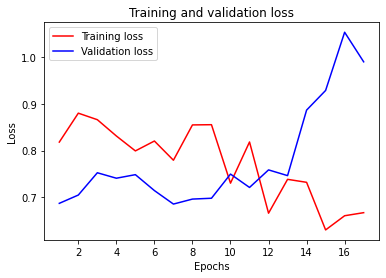

In [29]:
# Plotting training and validation loss for combined model
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
epochs = range(1, len(history.history['loss'] )+ 1)
plt.plot(epochs, loss_values, 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("com_model_loss.png")
plt.show()

In [30]:
# Prediction on the test dataset 
y_pred_com = (com_model.predict_generator(img_txt_gen_test,steps = 149))
y_pred_com = np.round(list(itertools.chain(*y_pred_com)))
y_true = y_test.values    # Test labels

#Prediction and true label display
print("predicted labels = ",y_pred_com)
print("true_labels = ",y_true)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


predicted labels =  [1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0.
 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1.
 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.
 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0.
 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0.
 1. 1. 1. 0. 0.]
true_labels =  [1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0
 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0
 0 0 1 0 0 1 1 1 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0
 0]


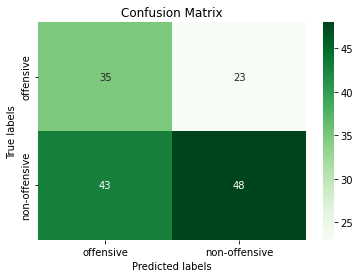

In [31]:
# Confusion matrix of combined model
labels = [1,0]
cm = confusion_matrix(y_true, y_pred_com, labels=labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap='Greens'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['offensive', 'non-offensive']); ax.yaxis.set_ticklabels(['offensive', 'non-offensive']);


In [32]:
# Perfromance Metrics of combined model
acc=com_model.evaluate_generator(img_txt_gen_test, steps=8)
y_true = y_test.values
pre,recall,fscore,support= precision_recall_fscore_support(y_true, y_pred_com, beta=1.0, labels=None, pos_label=1, average='binary')

print("accuracy = ",acc[1])
print("precision = ",pre)
print("recall = ",recall)
print("F1_score = ",fscore)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


accuracy =  0.625
precision =  0.44871794871794873
recall =  0.603448275862069
F1_score =  0.5147058823529411


In [ ]:
# !pip install session-info

In [36]:
# Generate requrements for reproducing experiement
import session_info
session_info.show()